In [1]:
import pandas as pd
import numpy as np
from chembl_webresource_client.new_client import new_client
from rdkit import Chem
from source.acquire_m import *
from source.model_marley import *
from scipy import stats as scs


%load_ext autoreload
%autoreload 2

RDKit WARNING: [10:14:02] Enabling RDKit 2019.09.3 jupyter extensions


In [2]:
# This cell takes in a disease we wish to target
wrangle_obj = wrangle('Coronavirus')

In [3]:
#This cell searches th ChEMBL database for the disease,
# it will return a df of single protien targets. Single protien targets are 
# important because these are what were are going to compare the chemical compounds to.

# *NOTE* This is the first acquire stage of aqcuire. Because of the complexity of this data 
# we must acquire twice, The first acquistion will be to find a target single protien of a disease or virus.
# The second aqcuisition will be using the chosen single protien target to find the chemical compounds tested
# against it, this is the ultimate end goal of the aqcuire and prepare steps.

# *NOTE* Because each protien is different we are providing a way to test each protien from the df
# in the df. They will each achieve a different result. 

acquire_df = wrangle_obj.acquire_data()
acquire_df

,index,cross_references,organism,pref_name,score,species_group_flag,target_chembl_id,target_components,target_type,tax_id
0,0,"[{'xref_id': 'P0C6U8', 'xref_name': None, 'xre...",SARS coronavirus,SARS coronavirus 3C-like proteinase,10.000,False,CHEMBL3927,"[{'accession': 'P0C6U8', 'component_descriptio...",SINGLE PROTEIN,227859
1,1,"[{'xref_id': 'P0C6X7', 'xref_name': None, 'xre...",SARS coronavirus,Replicase polyprotein 1ab,4.000,False,CHEMBL5118,"[{'accession': 'P0C6X7', 'component_descriptio...",SINGLE PROTEIN,227859
2,2,[],Severe acute respiratory syndrome coronavirus 2,Replicase polyprotein 1ab,4.000,False,CHEMBL4523582,"[{'accession': 'P0DTD1', 'component_descriptio...",SINGLE PROTEIN,2697049


In [4]:
# This cell provides a list of ChEMBL ID's. The user (that's you) will copy one of the id's
# and paste it into the input below, This function will create the dataframe for this specific 
# single protien target and is what will be used the rest of the notebook. If the user wants to run
# a different single protien target rerun this cell and paste a seperate ChEMBL id in the
# input, then rerun subsequent cells


bioactivity_df = wrangle_obj.get_bioactivity_data()
bioactivity_df

List of single protein ChEMBL ID's from chosen disease:
0       CHEMBL3927
1       CHEMBL5118
2    CHEMBL4523582
Name: target_chembl_id, dtype: object
Input a single protein target ID from the list:CHEMBL3927


,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,bao_label,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
activity_comment,,,,,,,,,,,,,,,,,,,,,
NaN,1480935,[],CHEMBL829584,In vitro inhibitory concentration against SARS...,B,NaN,NaN,BAO_0000190,BAO_0000357,single protein format,...,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,NaN,NaN,IC50,uM,UO_0000065,NaN,7.200
NaN,1480936,[],CHEMBL829584,In vitro inhibitory concentration against SARS...,B,NaN,NaN,BAO_0000190,BAO_0000357,single protein format,...,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,NaN,NaN,IC50,uM,UO_0000065,NaN,9.400
NaN,1481061,[],CHEMBL830868,In vitro inhibitory concentration against SARS...,B,NaN,NaN,BAO_0000190,BAO_0000357,single protein format,...,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,NaN,NaN,IC50,uM,UO_0000065,NaN,13.500
NaN,1481065,[],CHEMBL829584,In vitro inhibitory concentration against SARS...,B,NaN,NaN,BAO_0000190,BAO_0000357,single protein format,...,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,NaN,NaN,IC50,uM,UO_0000065,NaN,13.110
NaN,1481066,[],CHEMBL829584,In vitro inhibitory concentration against SARS...,B,NaN,NaN,BAO_0000190,BAO_0000357,single protein format,...,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,NaN,NaN,IC50,uM,UO_0000065,NaN,2.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NaN,12041507,[],CHEMBL2150313,Inhibition of SARS-CoV PLpro expressed in Esch...,B,NaN,NaN,BAO_0000190,BAO_0000019,assay format,...,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,NaN,NaN,IC50,uM,UO_0000065,NaN,10.600
NaN,12041508,[],CHEMBL2150313,Inhibition of SARS-CoV PLpro expressed in Esch...,B,NaN,NaN,BAO_0000190,BAO_0000019,assay format,...,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,NaN,NaN,IC50,uM,UO_0000065,NaN,10.100
NaN,12041509,[],CHEMBL2150313,Inhibition of SARS-CoV PLpro expressed in Esch...,B,NaN,NaN,BAO_0000190,BAO_0000019,assay format,...,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,NaN,NaN,IC50,uM,UO_0000065,NaN,11.500


 This cell is the second stage of the acquire and aquistion process. Here we will    create the dataframes and csv's 
 used  to look at the chemical coumpounds tested against the single protien target chosen. This adds the 5 lipinksi rules.
 - Moleculer Weight (size of the chemical, important for if its digestabile in the body)

 - Logp (solubility in fat and water)
 
 - NumHDonors(Number of hydrogen donors the cell has, important for chemical reactions)
 
 - NumHAcceptors(Number of hydrogen acceptors important for chemical reactions)
 
 - PIC50 (The Target | The negative log of th IC50 score. The IC50 Half-maximal inhibitory concentration (IC50) is the most widely used and informative measure of a drug's efficacy. It indicates how much drug is needed to inhibit a biological process by half, thus providing a measure of potency of an antagonist drug in pharmacological research. Its converted to negative log here for readibility and stabilization.)
 
 - Cannonical smile (a unique representation of the chemical compound being tested)

In [5]:
#This cell is the second stage of the acquire and aquistion process. Here we will create the dataframes and csv's 
# used  to look at the chemical coumpounds tested against. This adds the 5 lipinksi ru

wrangle_obj.prepare_dataframe()

,molecule_chembl_id,canonical_smiles,standard_value,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL187579,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,"7,200.000",INTERMEDIATE,281.271,1.893,0.000,5.000,5.143
1,CHEMBL188487,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,"9,400.000",INTERMEDIATE,415.589,3.813,0.000,2.000,5.027
2,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,"13,500.000",INACTIVE,421.190,2.661,0.000,4.000,4.870
3,CHEMBL426082,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,"13,110.000",INACTIVE,293.347,3.631,0.000,3.000,4.882
4,CHEMBL187717,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c1cccc2[N+](=O)[O-],"2,000.000",INTERMEDIATE,338.344,3.539,0.000,5.000,5.699
...,...,...,...,...,...,...,...,...,...
128,CHEMBL2146517,COC(=O)[C@@]1(C)CCCc2c1ccc1c2C(=O)C(=O)c2c(C)c...,"10,600.000",INACTIVE,338.359,3.401,0.000,5.000,4.975
129,CHEMBL187460,C[C@H]1COC2=C1C(=O)C(=O)c1c2ccc2c1CCCC2(C)C,"10,100.000",INACTIVE,296.366,3.443,0.000,3.000,4.996
130,CHEMBL363535,Cc1coc2c1C(=O)C(=O)c1c-2ccc2c(C)cccc12,"11,500.000",INACTIVE,276.291,4.096,0.000,3.000,4.939
131,CHEMBL227075,Cc1cccc2c3c(ccc12)C1=C(C(=O)C3=O)[C@@H](C)CO1,"10,700.000",INACTIVE,278.307,3.291,0.000,3.000,4.971


In [6]:
# Below is a kruskal wallis test run against the lipinski rules to test the distribution difference between active, inactive, and intermediate classes
# This funtion also creates a csv with the unique chemical fingerprints for each chemical compound.
wrangle_obj.preprocess_bioactivity_data(tests = True)

Saving 133 molecules.

Kruskal Wallis H tests for molecular descriptors (active vs. inactive)...

 MW
   H statistic = 12, p = 0.002
   Different distribution. Reject H0.

 LogP
   H statistic = 1, p = 0.644
   Same distribution. Fail to reject H0.

 NumHDonors
   H statistic = 23, p = 0.000
   Different distribution. Reject H0.

 NumHAcceptors
   H statistic = 13, p = 0.002
   Different distribution. Reject H0.

Computing fingerprints (takes several minutes if molecules > 1000)...
Success!



In [7]:
# This cell is used to to distinguish between which single protien target the user inputed

target_id = wrangle_obj.user_target

In [8]:
# Assigns the preprocessed csv created to a df
bioactivity_df = pd.read_csv(f'{target_id}_bioactivity_preprocessed.csv')

In [9]:
# Assigns the fingerprint csv created to a df
fingerprint_df = pd.read_csv(f'{target_id}_pubchem_fp.csv')

## Exploration

Three representations of molecule CHEMBL187579:

1. SMILES notation: Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21

2. Chemical fingerprint: [1 1 0 0 0 0 0 0 0 1 1 1 0 0 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0
 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 1 0 0 0 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 1 0 0 1 1 1 1 0 0 0 0 0 0 1 0 0 0 0
 1 1 0 0 1 0 1 1 0 0 0 1 0 0 1 0 0 1 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 1 1 1 0 0 1 0 0 0 

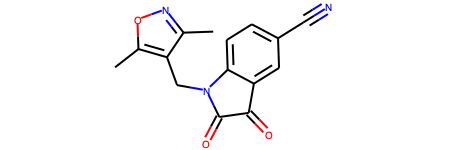

In [10]:
# The cell shows you three ways to visualize an example chemical compound being tested
# The example here is the first compound in our dataframe

mol = bioactivity_df.molecule_chembl_id.values[0]
SMILES = bioactivity_df.canonical_smiles[bioactivity_df.molecule_chembl_id==mol].values[0]
fingerprint = np.array(fingerprint_df[fingerprint_df.Name==mol])[0][1:]

print(f'Three representations of molecule {mol}:')
print()
print('1. SMILES notation:', SMILES)
print()
print('2. Chemical fingerprint:', fingerprint)
print()
print(' 3. Molecular Visualization')
Chem.MolFromSmiles(SMILES) #an example molecule

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = (5,5)
plt.style.use('fivethirtyeight')

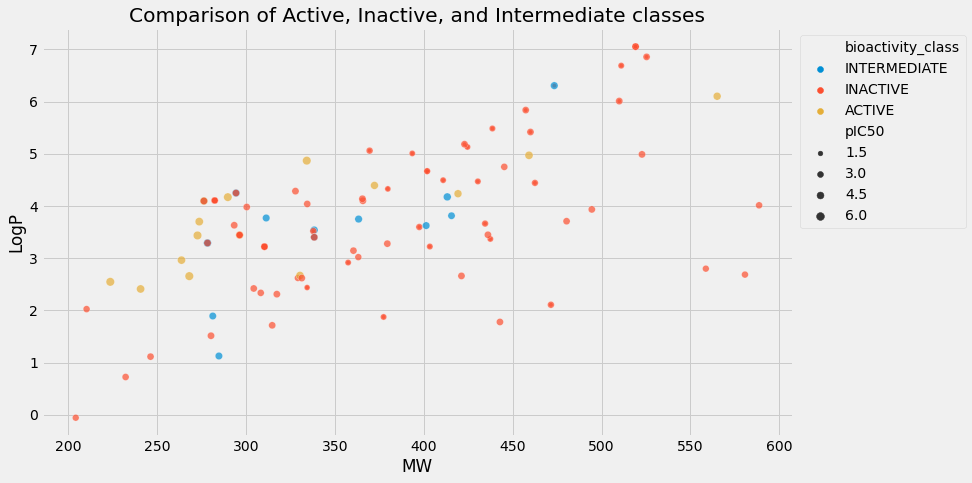

In [21]:
plt.figure(figsize=(12, 7))
sns.scatterplot(x='MW', y='LogP', data=bioactivity_df, hue='bioactivity_class', size='pIC50', alpha=.7)
plt.legend(bbox_to_anchor=(1,1))
plt.title('Comparison of Active, Inactive, and Intermediate classes')
plt.show()

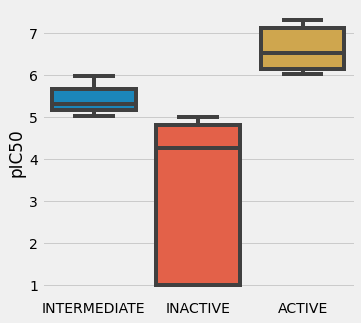

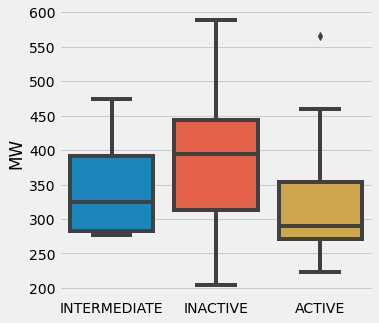

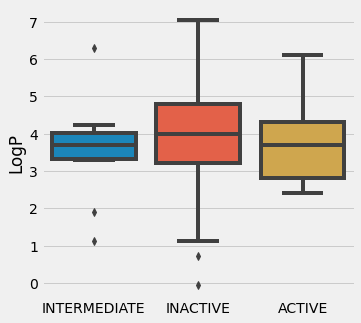

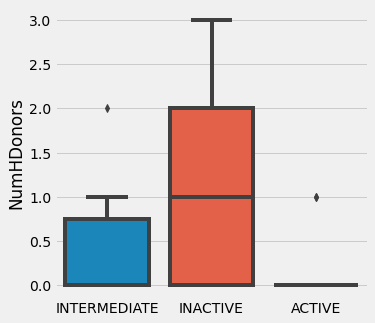

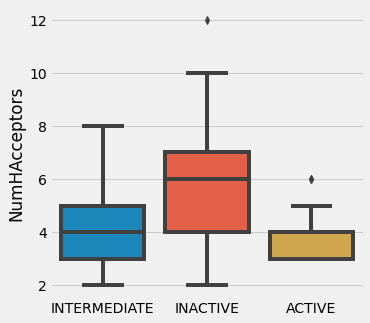

In [13]:
for column in ['pIC50', 'MW', 'LogP', 'NumHDonors', 'NumHAcceptors']:
    sns.boxplot(x='bioactivity_class', y=column, data=bioactivity_df)
    plt.xlabel('')
    plt.show()

<a id='Model'></a>
## 4. Modeling the chemical fingerprints

In this part, we use machine learning to determine the charchteristics of molecules with a high chance of being viable drug candidates.

A note on modeling: $R^2$ is the percent of the variance in [potency](https://en.wikipedia.org/wiki/Potency_(pharmacology)) (as measured by $pIC_{50}$) is explained by the chemical fingerprint of the molecule.

In [14]:
# Modeling imports
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import VarianceThreshold
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

In [15]:
modeling_df, target = premodeling_processing(bioactivity_df, fingerprint_df)
modeling_df.head()

,molecule_id,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,...,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL187579,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,281.271,1.893,0.000,5.000
1,CHEMBL188487,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,415.589,3.813,0.000,2.000
2,CHEMBL185698,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,421.190,2.661,0.000,4.000
3,CHEMBL426082,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,293.347,3.631,0.000,3.000
4,CHEMBL365134,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,372.243,4.393,0.000,3.000


In [16]:
target.head()

,pIC50,bioactivity_class,standard_value
0,5.143,0,"7,200.000"
1,5.027,0,"9,400.000"
2,4.870,1,"13,500.000"
3,4.882,1,"13,110.000"
4,6.009,2,980.000


In [17]:
names = ['Linear Regressor', 'Random Forrest Regressor', 'Tweedies Regressor']
models = [LinearRegression(normalize = True), RandomForestRegressor(), TweedieRegressor()]

In [18]:
model_obj = Modeling_class(modeling_df, target, models, names)

In [19]:
avg_metrics, outputs = model_obj.regression_modeling(splits = 10)

Have not run scaling method yet, running now...
All done! Moving on to modeling, this may take a while...
Modeling done! Average scores are abstract represntations of how well this model type did, not actual scores.


In [20]:
avg_metrics

avg_score
model                    metric                                                             
Linear Regressor         neg_root_mean_squared_error                  13,278,331,433,899.764
                         r2                          119,294,163,927,682,548,649,426,944.000
Random Forrest Regressor neg_root_mean_squared_error                                   1.505
                         r2                                                            0.246
Tweedies Regressor       neg_root_mean_squared_error                                   1.288
                         r2                                                            0.433

**For the sake of data integrity we have not run on test, this is a mvp.**